Here we will test our single view models and our multiview model using the generated data.

In [16]:
import os
import keras
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from transformers import AutoTokenizer, TFAutoModel
import tensorflow_datasets as tfds
from keras.datasets import mnist 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, auc, f1_score
from keras.applications.resnet50 import preprocess_input

from PIL import Image
from keras.callbacks import EarlyStopping
from keras.applications.resnet50 import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D, Input
from keras.models import Model

%load_ext autoreload
%autoreload 2
from utils import show_performance_metrics, preprocess_image, augment_image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# --- Configuration ---
# Image dimensions for ResNet50 input
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3 # ResNet50 expects 3 channels (RGB)

# Batch size for training
BATCH_SIZE = 16 

# Number of epochs for training the classifier head
EPOCHS = 30

# Learning rate for the classifier head
LEARNING_RATE = 1e-4

seed = 42

In [5]:
# ---  Data Loading from CSV ---
# Load CSV file
try:
    df = pd.read_csv('../handwriting_generation/dyslexia_handwriting_dataset.csv')
    print("--- Successfully loaded dyslexia_handwriting_dataset.csv ---")
except FileNotFoundError:
    print("Error: 'dyslexia_handwriting_dataset.csv' not found. Please ensure the CSV file is in the same directory as the script.")
    # Exit or handle the error appropriately
    exit()

if 'file_path' not in df.columns or 'text' not in df.columns or 'presence_of_dyslexia' not in df.columns:
    print("Error: CSV must contain 'file_path', 'text', and 'presence_of_dyslexia' columns.")
    exit()

# Convert labels to integer type
df['presence_of_dyslexia'] = df['presence_of_dyslexia'].astype(int)

print("--- DataFrame Head ---")
print(df.head())
print("\n--- Value Counts for Dyslexia Presence ---")
print(df['presence_of_dyslexia'].value_counts())

--- Successfully loaded dyslexia_handwriting_dataset.csv ---
--- DataFrame Head ---
   presence_of_dyslexia                                          file_path  \
0                     0  ../data/normal_handwriting_images/normal_sampl...   
1                     0  ../data/normal_handwriting_images/normal_sampl...   
2                     0  ../data/normal_handwriting_images/normal_sampl...   
3                     0  ../data/normal_handwriting_images/normal_sampl...   
4                     0  ../data/normal_handwriting_images/normal_sampl...   

                                                text  
0  My best friend, Violet, has a navy pet hedgeho...  
1  My best friend, Kevin, has a silver pet parrot...  
2  My best friend, George, has a navy pet fish. G...  
3  My best friend, Mia, has a gold pet budgie. Mi...  
4  My best friend, Laura, has a yellow pet hamste...  

--- Value Counts for Dyslexia Presence ---
presence_of_dyslexia
0    500
1    500
Name: count, dtype: int64


# 1  Single View model Using Images


Total files: 1000
Training files: 700 (70.0%)
Validation files: 150 (15.0%)
Test files: 150 (15.0%)

--- tf.data.Dataset created successfully ---

--- Model Summary (Initial Frozen Layers) ---


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)


--- Training the model for 30 epochs ---
Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 227ms/step - accuracy: 0.8610 - loss: 0.2723 - val_accuracy: 0.9467 - val_loss: 0.1371
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 204ms/step - accuracy: 0.9748 - loss: 0.0611 - val_accuracy: 0.9667 - val_loss: 0.0756
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 205ms/step - accuracy: 0.9894 - loss: 0.0372 - val_accuracy: 0.9733 - val_loss: 0.0456
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 202ms/step - accuracy: 0.9779 - loss: 0.0385 - val_accuracy: 0.9800 - val_loss: 0.0495
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 204ms/step - accuracy: 0.9796 - loss: 0.0481 - val_accuracy: 0.9800 - val_loss: 0.0368
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 205ms/step - accuracy: 0.9922 - loss: 0.0234 - val_accuracy: 0.9733 - val_loss: 0.0474
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 203ms/step - accuracy: 0.9962 - loss: 0.0149 - val_accuracy: 0.9867 - val_loss: 0.0387
Epoch 8/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 207ms/step - accurac

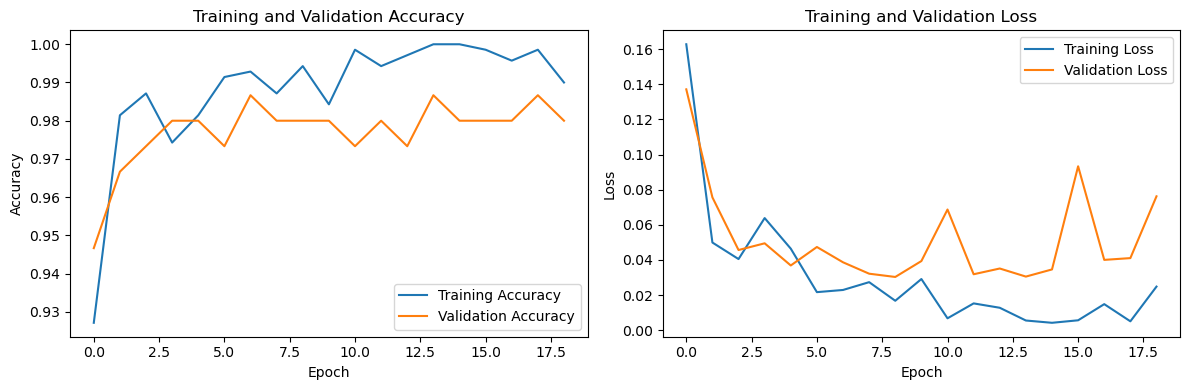

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step

Confusion Matrix:


2025-08-22 12:00:39.168716: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


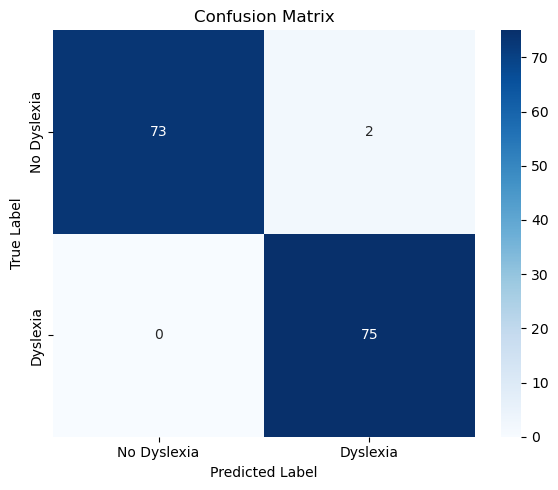


Additional Metrics for Test Results:
Sensitivity (Recall): 1.0000
Specificity: 0.9733
F1 Score: 0.9868

Classification Report:
              precision    recall  f1-score   support

 No Dyslexia       1.00      0.97      0.99        75
    Dyslexia       0.97      1.00      0.99        75

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150

ROC AUC Score (Prob-based): 1.0000
PR AUC Score: 1.0000


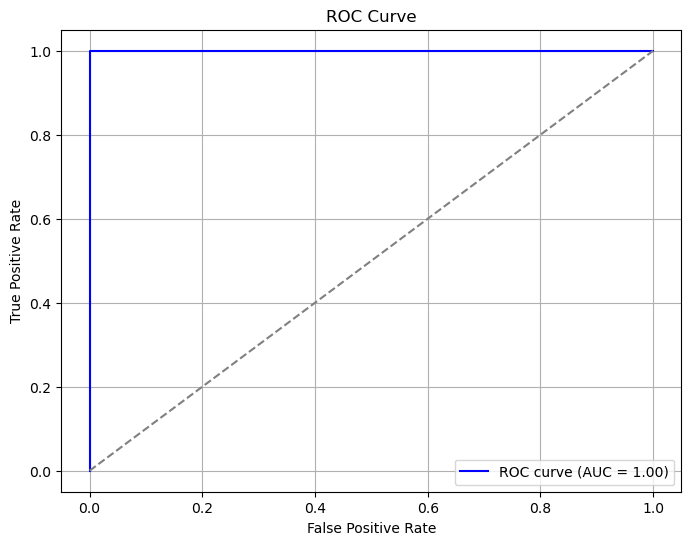

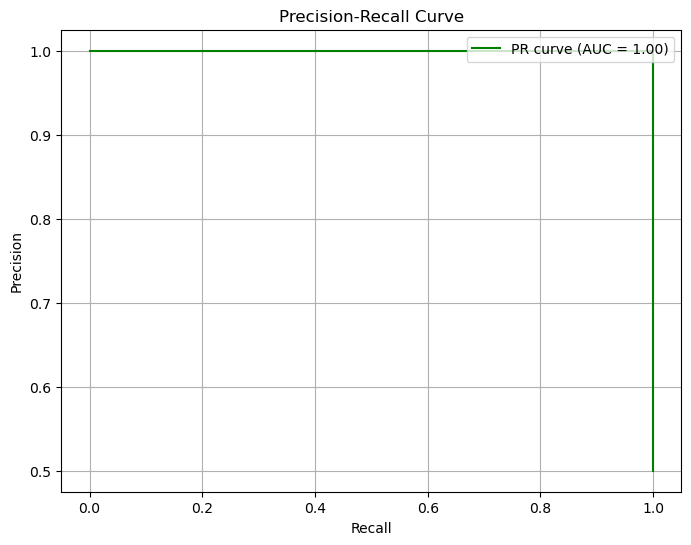

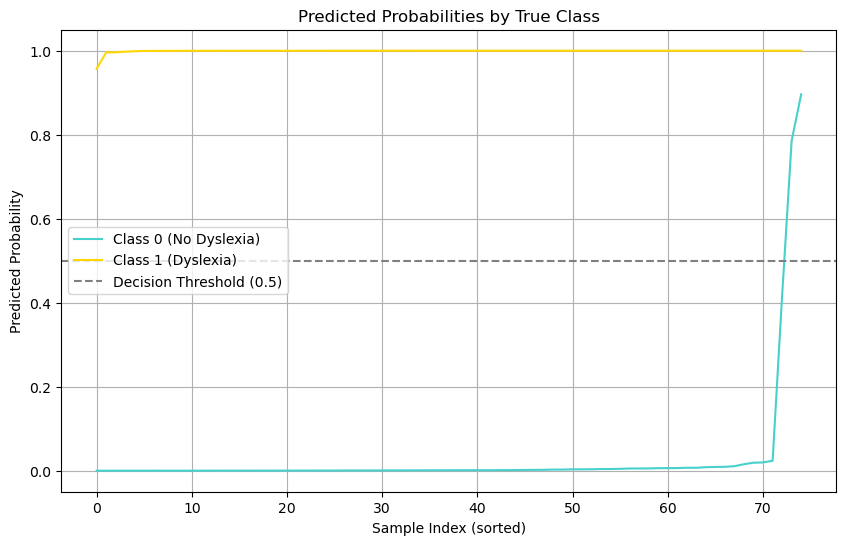

In [6]:
# Create Single View model using handwriting images 

# --- 2. Data Splitting ---
# 70% Training, 15% Validation, 15% Testing

# First, split into training and (validation + test)
train_df, val_test_df = train_test_split(
    df,
    test_size=0.3, # 30% for validation + test
    stratify=df['presence_of_dyslexia'], # Maintain class distribution
    random_state=seed
)

# Then, split (validation + test) into validation and test
val_df, test_df = train_test_split(
    val_test_df,
    test_size=0.5, 
    stratify=val_test_df['presence_of_dyslexia'], # Maintain class distribution
    random_state=seed
)

print(f"\nTotal files: {len(df)}")
print(f"Training files: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"Validation files: {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")
print(f"Test files: {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")

# ---  Image Preprocessing and tf.data.Dataset creation ---

# Create tf.data.Dataset from DataFrames
def create_dataset(dataframe, augment=False, shuffle=False):
    # Convert file_path and presence_of_dyslexia columns to TensorFlow tensors
    file_paths = tf.constant(dataframe['file_path'].tolist())
    labels = tf.constant(dataframe['presence_of_dyslexia'].tolist(), dtype=tf.float32)

    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(dataframe), seed=seed)

    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

    if augment:
        dataset = dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

train_dataset = create_dataset(train_df, augment=True, shuffle=True)
validation_dataset = create_dataset(val_df, augment=False, shuffle=False)
test_dataset = create_dataset(test_df, augment=False, shuffle=False)

print("\n--- tf.data.Dataset created successfully ---")

# ---  Model Building (ResNet50 for Binary Classification) ---
# Load ResNet50 model with pre-trained ImageNet weights, excluding the top classification layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Freeze the base model layers to prevent their weights from being updated during initial training.
# This uses the pre-learned features from ImageNet as-is.
base_model.trainable = False

# Add custom classification layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x) # Reduces spatial dimensions to 1x1, to capture global features
x = Dense(256, activation='relu')(x) # A dense layer before the final output
predictions = Dense(1, activation='sigmoid')(x) # Output layer for binary classification

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
# Using Adam optimizer, binary_crossentropy for binary classification, and accuracy as metric
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("\n--- Model Summary (Initial Frozen Layers) ---")
model.summary()

# ---  Model Training ---
# Define the EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)
print(f"\n--- Training the model for {EPOCHS} epochs ---")
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    callbacks=[early_stopping_callback]
)

'''# Optional: Fine-tuning (unfreeze some layers and train again with a lower learning rate)
# Can try this for small datasets to adapt the pre-trained features.
print("\n--- Fine-tuning: Unfreezing top layers of ResNet50 ---")
base_model.trainable = True # Unfreeze the base model

# Unfreeze a small number of layers from the top of the base model
# and keep the lower layers (earlier layers) frozen, as they learn more generic features.
# The `len(base_model.layers) - 50`` unfreezes the last 50 layers.
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), # Very low learning rate
              loss='binary_crossentropy',
              metrics=['accuracy'])

print("\n--- Model Summary (After Unfreezing) ---")
model.summary()

# Continue training for a few more epochs
fine_tune_epochs = 10
total_epochs = epochs + fine_tune_epochs

# Define the EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

print(f"\n--- Fine-tuning the model for {fine_tune_epochs} more epochs ---")
history_fine_tune = model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1], # Start from where previous training left off
    validation_data=validation_dataset,
    callbacks=[early_stopping_callback]
)'''

# ---  Model Evaluation ---
print("\n--- Evaluating the model on the test set ---")
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# ---   Save the model ---
# model_save_path = 'dyslexia_detection_resnet50.h5'
# model.save(model_save_path)
# print(f"\nModel saved to {model_save_path}")

# ---  Visualize Training History ---
# Combine history from initial training and fine-tuning
acc = history.history['accuracy'] #+ history_fine_tune.history['accuracy']
val_acc = history.history['val_accuracy'] #+ history_fine_tune.history['val_accuracy']
loss = history.history['loss'] #+ history_fine_tune.history['loss']
val_loss = history.history['val_loss'] #+ history_fine_tune.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

all_preds = []
all_labels = []

for inputs, labels in test_dataset:
    predictions = model.predict(inputs)
    all_preds.extend(predictions.flatten().tolist())
    all_labels.extend(labels.numpy().flatten().tolist())

# Generate and display performance metrics and classification report
show_performance_metrics(all_labels, all_preds)

# 2  Single View model using transcript text 

Loading BERT tokenizer and tokenizing all text...
All text tokenized. Input IDs shape: (1000, 128), Attention Masks shape: (1000, 128)
Training samples: 700
Validation samples: 150
TensorFlow Datasets created from preprocessed NumPy arrays for text.
Building single-view text model architecture...


/config/anaconda3/envs/imperial_3_12_linux/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model fro

BERT model wrapped in custom layer and layers frozen.
Compiling text model...


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ attention_mask      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_ids           │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_feature_extra… │ (None, 768)       │          0 │ attention_mask[0… │
│ (BertEmbeddingLaye… │                   │            │ input_ids[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │    196,864 │ bert_feature_ext… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │        257 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 197,121 (770.00 KB)

 Trainable params: 197,121 (770.00 KB)

 Non-trainable params: 0 (0.00 B)

Training text model...
Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 570ms/step - accuracy: 0.7328 - loss: 0.5605 - val_accuracy: 0.9467 - val_loss: 0.2556
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 23s 514ms/step - accuracy: 0.9287 - loss: 0.2846 - val_accuracy: 0.9467 - val_loss: 0.1686
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 23s 514ms/step - accuracy: 0.9250 - loss: 0.2337 - val_accuracy: 0.9467 - val_loss: 0.1418
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 23s 515ms/step - accuracy: 0.9323 - loss: 0.2184 - val_accuracy: 0.9600 - val_loss: 0.1263
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 23s 514ms/step - accuracy: 0.9351 - loss: 0.2151 - val_accuracy: 0.9733 - val_loss: 0.1157
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 23s 516ms/step - accuracy: 0.9313 - loss: 0.2031 - val_accuracy: 0.9733 - val_loss: 0.1084
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 23s 517ms/step - accuracy: 0.9336 - loss: 0.1877 - val_accuracy: 0.9800 - val_loss: 0.1030
Epoch 8/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 22s 511ms/step - accuracy: 0.9383 - 

2025-08-22 13:07:35.705185: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


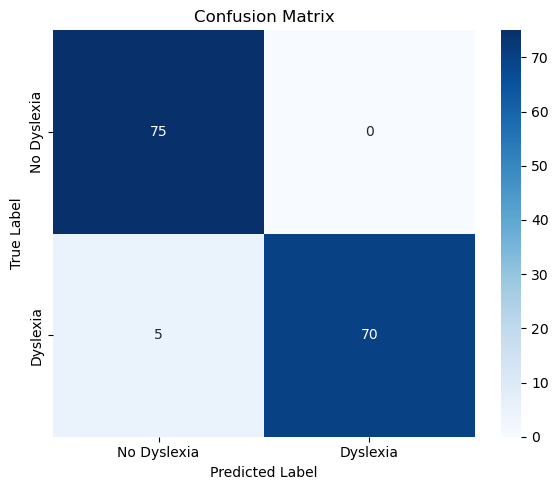


Additional Metrics for Test Results:
Sensitivity (Recall): 0.9333
Specificity: 1.0000
F1 Score: 0.9655

Classification Report:
              precision    recall  f1-score   support

 No Dyslexia       0.94      1.00      0.97        75
    Dyslexia       1.00      0.93      0.97        75

    accuracy                           0.97       150
   macro avg       0.97      0.97      0.97       150
weighted avg       0.97      0.97      0.97       150

ROC AUC Score (Prob-based): 0.9758
PR AUC Score: 0.9841


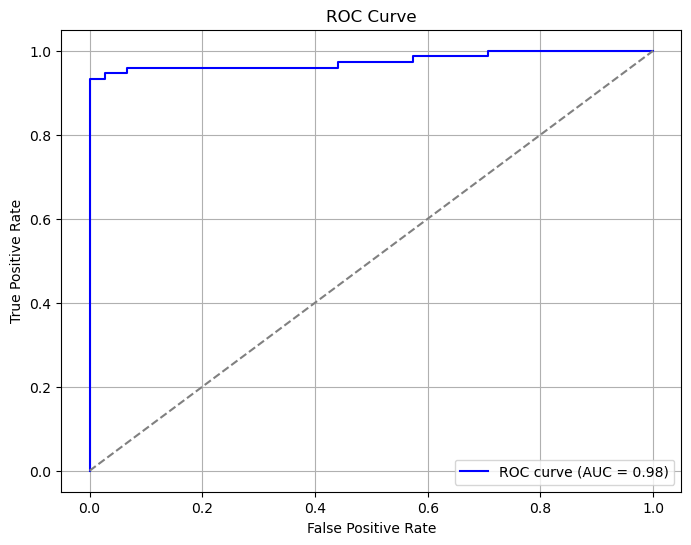

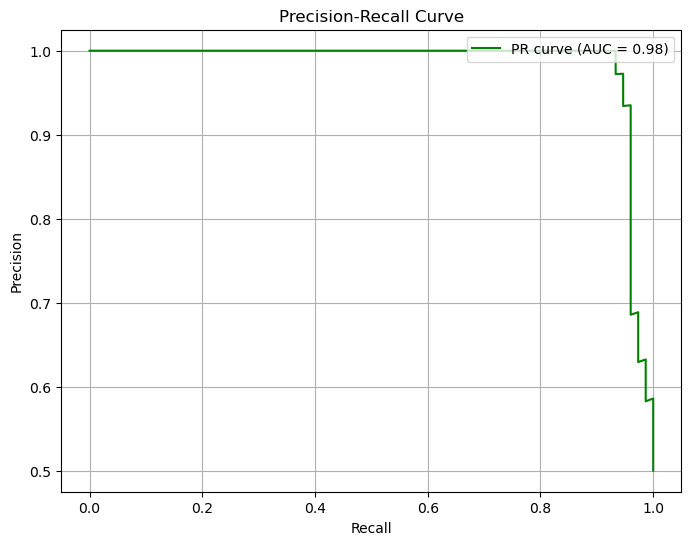

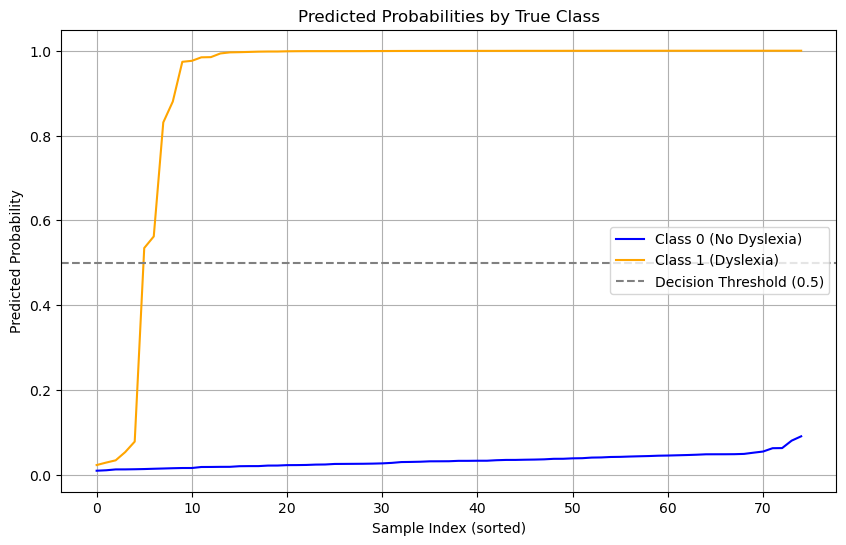


Text single-view model training and evaluation complete.


In [10]:
# Create Single View model using transcript text 
# --- Text Tokenization (Pre-tokenizing all text) ---
print("Loading BERT tokenizer and tokenizing all text...")
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased") 

all_input_ids = []
all_attention_masks = []

for text_entry in df['text']:
    encoded_input = tokenizer(
        text_entry,
        padding='max_length',
        truncation=True,
        max_length=128, # Consistent max length
        return_tensors='np'
    )
    all_input_ids.append(encoded_input['input_ids'][0])
    all_attention_masks.append(encoded_input['attention_mask'][0])

all_input_ids = np.array(all_input_ids)
all_attention_masks = np.array(all_attention_masks)
print(f"All text tokenized. Input IDs shape: {all_input_ids.shape}, Attention Masks shape: {all_attention_masks.shape}")

# ---  Split Processed data: 70% Train, 15% Validation, 15% Test for Text Data ---
# Split into Training (70%) and Temporary (30%)
# The 'temp' set will later be split into validation and test.
X_input_ids_train, X_input_ids_temp, \
X_attention_masks_train, X_attention_masks_temp, \
y_train_text_split, y_temp_text_split = train_test_split(
    all_input_ids,
    all_attention_masks,
    df['presence_of_dyslexia'].values,
    test_size=0.3,   
    random_state=seed,
    stratify=df['presence_of_dyslexia'].values # Stratify based on the full labels
)

# Step 2: Split the Temporary set (30%) into Validation (15%) and Test (15%)
X_input_ids_val, X_input_ids_test, \
X_attention_masks_val, X_attention_masks_test, \
y_val_text_split, y_test_text_split = train_test_split(
    X_input_ids_temp,
    X_attention_masks_temp,
    y_temp_text_split, 
    test_size=0.5,  
    random_state=seed,  
    stratify=y_temp_text_split # Stratify based on the labels from the temp set
)

print(f"Training samples: {len(y_train_text_split)}")
print(f"Validation samples: {len(y_val_text_split)}")

# --- Create TensorFlow Datasets from NumPy arrays (for text only) ---
def create_tf_text_dataset_from_np(input_ids, attention_masks, labels):
    """
    Creates a TensorFlow Dataset from NumPy arrays for text data.
    """
    ds = tf.data.Dataset.from_tensor_slices(
        (
            {'input_ids': input_ids, 'attention_mask': attention_masks},
            labels
        )
    )
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_dataset_text = create_tf_text_dataset_from_np(X_input_ids_train, X_attention_masks_train, y_train_text_split)
val_dataset_text = create_tf_text_dataset_from_np(X_input_ids_val, X_attention_masks_val, y_val_text_split)
test_dataset_text = create_tf_text_dataset_from_np(X_input_ids_test, X_attention_masks_test, y_test_text_split)

print("TensorFlow Datasets created from preprocessed NumPy arrays for text.")

# --- Custom Keras Layer for BERT Model (re-used from multi-view) ---
class BertEmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self, model_name, **kwargs):
        super().__init__(**kwargs)
        self.bert_model = TFAutoModel.from_pretrained(model_name, from_pt=True) 
        self.bert_model.trainable = False # Keep BERT layers frozen for feature extraction

    def call(self, inputs):
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        bert_output = self.bert_model(input_ids, attention_mask=attention_mask, training=False)
        # The [CLS] token output is at index 0 of the last_hidden_state
        return bert_output.last_hidden_state[:, 0, :]

    def get_config(self):
        config = super().get_config()
        config.update({"model_name": "bert-base-cased"}) 
        return config

# --- Define the Single-View Text Model ---
print("Building single-view text model architecture...")

# Text Branch (BERT) using the custom layer
bert_input_ids = keras.Input(shape=(128,), dtype=tf.int32, name='input_ids')
bert_attention_mask = keras.Input(shape=(128,), dtype=tf.int32, name='attention_mask')

bert_embedding_extractor = BertEmbeddingLayer("bert-base-cased", name="bert_feature_extractor")  
text_features = bert_embedding_extractor({'input_ids': bert_input_ids, 'attention_mask': bert_attention_mask})
print("BERT model wrapped in custom layer and layers frozen.")

# Classifier Head (New layers to be trained)
classifier_head = layers.Dense(256, activation='relu')(text_features)
classifier_head = layers.Dropout(0.5)(classifier_head)
#classifier_head = layers.Dense(128, activation='relu')(classifier_head)
#classifier_head = layers.Dropout(0.3)(classifier_head)
output_layer = layers.Dense(1, activation='sigmoid', name='output')(classifier_head)

# Create the final single-view text model
text_model = keras.Model(
    inputs={'input_ids': bert_input_ids, 'attention_mask': bert_attention_mask},
    outputs=output_layer
)

# --- Compile and Train the Text Model ---
print("Compiling text model...")
text_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

text_model.summary()

# Define the EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

print("Training text model...")
history_text = text_model.fit(
    train_dataset_text,
    epochs=EPOCHS,
    validation_data=val_dataset_text,
    callbacks=[early_stopping_callback]
)

# --- Evaluation for Text Model ---
print("\nEvaluating text model on validation set...")
test_loss_text, test_accuracy_text = text_model.evaluate(test_dataset_text)
print(f"Text Model Test Loss: {test_loss_text:.4f}")
print(f"Text Model Test Accuracy: {test_accuracy_text:.4f}")

# Generate predictions and classification report for text model
all_preds_text = []
all_labels_text = []
# Create a dataset for prediction from validation data for text
predict_dataset_text = tf.data.Dataset.from_tensor_slices(
    (
        {'input_ids': X_input_ids_test, 'attention_mask': X_attention_masks_test},
        y_test_text_split
    )
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for inputs, labels in predict_dataset_text:
    predictions = text_model.predict(inputs)
    all_preds_text.extend(predictions.flatten().tolist())
    all_labels_text.extend(labels.numpy().flatten().tolist())

# Convert probabilities to binary predictions (0 or 1)
binary_preds_text = np.array(all_preds_text) > 0.5

print("\nClassification Report (Text Model):")
print(classification_report(all_labels_text, binary_preds_text))

print("\nConfusion Matrix (Text Model):")
print(confusion_matrix(all_labels_text, binary_preds_text))

all_preds = []
all_labels = []

for inputs, labels in test_dataset_text:
    predictions = text_model.predict(inputs)
    all_preds.extend(predictions.flatten().tolist())
    all_labels.extend(labels.numpy().flatten().tolist())

# Generate predictions and classification report
show_performance_metrics(all_labels, all_preds)

print("\nText single-view model training and evaluation complete.")

# 3 Multiview model using both handwriting and transcript text 

In [ ]:
# Create MultiView model using both handwriting and transcript text 
df['text'] = df['text'].fillna('').astype(str) # Fill NaN with empty string, then convert to str
print(f"Total samples: {len(df)}")

# --- Image Preprocessing (Pre-loading all images) ---
print("Loading and preprocessing all images...")
all_images = []
for index, row in df.iterrows():
    image_path = row['file_path']
    full_image_path = image_path
    try:
        # Load image file
        img = tf.io.read_file(full_image_path)
        # Decode image 
        img = tf.image.decode_jpeg(img, channels=3) # Use decode_png for PNGs
        # Resize image
        img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
        # Apply ResNet50 specific preprocessing
        img = tf.keras.applications.resnet50.preprocess_input(img)
        all_images.append(img)
    except Exception as e:
        print(f"Error loading image {full_image_path}: {e}. Appending black image placeholder.")
        all_images.append(np.zeros((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32))

all_images = np.array(all_images)
print(f"All images loaded. Shape: {all_images.shape}")

# --- Text Tokenization (Pre-tokenizing all text) ---
print("Loading BERT tokenizer and tokenizing all text...")
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

all_input_ids = []
all_attention_masks = []

for text_entry in df['text']:
    encoded_input = tokenizer(
        text_entry, 
        padding='max_length',
        truncation=True,
        max_length=128, # Consistent max length
        return_tensors='np'  
    )
    # Crucial change: Access the first (and only) item in the batch dimension [0]
    all_input_ids.append(encoded_input['input_ids'][0])
    all_attention_masks.append(encoded_input['attention_mask'][0])

all_input_ids = np.array(all_input_ids)
all_attention_masks = np.array(all_attention_masks)
print(f"All text tokenized. Input IDs shape: {all_input_ids.shape}, Attention Masks shape: {all_attention_masks.shape}")

# Step 1: Split into Training (70%) and Temporary (30%)
X_images_train, X_images_temp, \
X_input_ids_train, X_input_ids_temp, \
X_attention_masks_train, X_attention_masks_temp, \
y_train, y_temp = train_test_split(
    all_images,
    all_input_ids,
    all_attention_masks,
    df['presence_of_dyslexia'].values,
    test_size=0.3,  # 30% for temp set (which will become val + test)
    random_state=42,
    stratify=df['presence_of_dyslexia'].values
)

# Step 2: Split the Temporary set (30%) into Validation (15%) and Test (15%)
# Now, the 'temp' set (which is 30% of the original data) needs to be split in half
# to get 15% for validation and 15% for test.
# So, test_size for this second split is 0.5 (50% of the temp set)
X_images_val, X_images_test, \
X_input_ids_val, X_input_ids_test, \
X_attention_masks_val, X_attention_masks_test, \
y_val, y_test = train_test_split(
    X_images_temp,
    X_input_ids_temp,
    X_attention_masks_temp,
    y_temp,
    test_size=0.5,  # 50% of the temp set (0.5 * 0.3 = 0.15 = 15%)
    random_state=42, # Keep the same random_state for reproducibility
    stratify=y_temp # Stratify based on the labels of the temp set
)

print(f"Training samples: {len(y_train)}")
print(f"Validation samples: {len(y_val)}")
print(f"Test samples: {len(y_val)}")

# --- Create TensorFlow Datasets from NumPy arrays ---
def create_tf_dataset_from_np(images, input_ids, attention_masks, labels, augment=False):
    """
    Creates a TensorFlow Dataset from NumPy arrays.
    Applies augmentation as a TensorFlow operation if specified.
    """
    ds = tf.data.Dataset.from_tensor_slices(
        (
            {'image_input': images, 'input_ids': input_ids, 'attention_mask': attention_masks},
            labels
        )
    )

    if augment:
        def apply_augmentation(inputs, label):
            img = inputs['image_input']
            # Apply random augmentation for training images using TF ops
            img = tf.image.random_flip_left_right(img)
            img = tf.image.random_brightness(img, max_delta=0.2)
            img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
        
            inputs['image_input'] = img
            return inputs, label
        ds = ds.map(apply_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_dataset = create_tf_dataset_from_np(X_images_train, X_input_ids_train, X_attention_masks_train, y_train, augment=False)
val_dataset = create_tf_dataset_from_np(X_images_val, X_input_ids_val, X_attention_masks_val, y_val, augment=False)
test_dataset = create_tf_dataset_from_np(X_images_test, X_input_ids_test, X_attention_masks_test, y_test, augment=False)


print("TensorFlow Datasets created from preprocessed NumPy arrays.")

# --- Custom Keras Layer for BERT Model ---
class BertEmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self, model_name, **kwargs):
        super().__init__(**kwargs)
        self.bert_model = TFAutoModel.from_pretrained(model_name, from_pt=True) 
        self.bert_model.trainable = False

    def call(self, inputs):
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        # The training=False argument is crucial to prevent issues with symbolic tensors
        bert_output = self.bert_model(input_ids, attention_mask=attention_mask, training=False)
        # The [CLS] token output is typically at index 0 of the last_hidden_state
        return bert_output.last_hidden_state[:, 0, :]

    def get_config(self):
        config = super().get_config()
        config.update({"model_name": "bert-base-cased"}) 
        return config

# --- Define the Multi-Modal Model ---
print("Building multi-modal model architecture...")

# Image Branch (ResNet50)
resnet_input = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), name='image_input')
resnet_model = keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=resnet_input
)

# Freeze ResNet50 layers
resnet_model.trainable = False
print("ResNet50 model loaded and layers frozen.")

# Extract features from ResNet50 output
image_features = resnet_model.output
image_features = layers.GlobalAveragePooling2D()(image_features)

# Text Branch (BERT) using the custom layer
bert_input_ids = keras.Input(shape=(128,), dtype=tf.int32, name='input_ids')
bert_attention_mask = keras.Input(shape=(128,), dtype=tf.int32, name='attention_mask')

bert_embedding_extractor = BertEmbeddingLayer("bert-base-cased", name="bert_feature_extractor")
text_features = bert_embedding_extractor({'input_ids': bert_input_ids, 'attention_mask': bert_attention_mask})
print("BERT model wrapped in custom layer and layers frozen.")

# Concatenate features from both modalities
concatenated_features = layers.Concatenate()([image_features, text_features])

# Classifier Head (New layers to be trained)
classifier_head = layers.Dense(256, activation='relu')(concatenated_features)
classifier_head = layers.Dropout(0.5)(classifier_head)
#classifier_head = layers.Dense(128, activation='relu')(classifier_head)
#classifier_head = layers.Dropout(0.3)(classifier_head)
output_layer = layers.Dense(1, activation='sigmoid', name='output')(classifier_head)

# Create the final multi-modal model
model = keras.Model(
    inputs={'image_input': resnet_input, 'input_ids': bert_input_ids, 'attention_mask': bert_attention_mask},
    outputs=output_layer
)

# --- Compile and Train the Model ---
print("Compiling model...")
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

model.summary()

# Define the EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

print("Training model...")
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping_callback]
)

# --- Evaluation ---
print("\nEvaluating model on Test set...")
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generate predictions and classification report
all_preds = []
all_labels = []
# Create a dataset for prediction from validation data
predict_dataset = tf.data.Dataset.from_tensor_slices(
    (
        {'image_input': X_images_test, 'input_ids': X_input_ids_test, 'attention_mask': X_attention_masks_test},
        y_test
    )
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for inputs, labels in predict_dataset:
    predictions = model.predict(inputs)
    all_preds.extend(predictions.flatten().tolist())
    all_labels.extend(labels.numpy().flatten().tolist())

# Convert probabilities to binary predictions (0 or 1)
binary_preds = np.array(all_preds) > 0.5

print("\nClassification Report:")
print(classification_report(all_labels, binary_preds))

print("\nConfusion Matrix:")
print(confusion_matrix(all_labels, binary_preds))

print("\nModel training and evaluation complete.")


Total samples: 1000
Loading and preprocessing all images...
All images loaded. Shape: (1000, 224, 224, 3)
Loading BERT tokenizer and tokenizing all text...
All text tokenized. Input IDs shape: (1000, 128), Attention Masks shape: (1000, 128)


/config/anaconda3/envs/imperial_3_12_linux/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Training samples: 700
Validation samples: 150
Test samples: 150
TensorFlow Datasets created from preprocessed NumPy arrays.
Building multi-modal model architecture...
ResNet50 model loaded and layers frozen.


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

BERT model wrapped in custom layer and layers frozen.
Compiling model...


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ image_input[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,309,121 (92.73 MB)

 Trainable params: 721,409 (2.75 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Training model...
Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 38s 735ms/step - accuracy: 0.7750 - loss: 0.4556 - val_accuracy: 0.9933 - val_loss: 0.0908
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 668ms/step - accuracy: 0.9704 - loss: 0.1117 - val_accuracy: 0.9933 - val_loss: 0.0451
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 665ms/step - accuracy: 0.9799 - loss: 0.0698 - val_accuracy: 0.9933 - val_loss: 0.0323
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 666ms/step - accuracy: 0.9867 - loss: 0.0566 - val_accuracy: 0.9933 - val_loss: 0.0263
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 666ms/step - accuracy: 0.9929 - loss: 0.0442 - val_accuracy: 0.9933 - val_loss: 0.0217
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 664ms/step - accuracy: 0.9892 - loss: 0.0353 - val_accuracy: 0.9933 - val_loss: 0.0181
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 666ms/step - accuracy: 0.9885 - loss: 0.0352 - val_accuracy: 1.0000 - val_loss: 0.0156
Epoch 8/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 666ms/step - accuracy: 0.9877 - loss:

# 4 Existing MultiView model with added Noise Image View

In [ ]:
# Noise Image dimensions
NOISE_IMG_HEIGHT = 224
NOISE_IMG_WIDTH = 224
NOISE_IMG_CHANNELS = 3

df['text'] = df['text'].fillna('').astype(str) # Fill NaN with empty string, then convert to str
print(f"Total samples: {len(df)}")

# --- Image Preprocessing (Pre-loading all images) ---
print("Loading and preprocessing all images...")
all_images = []
for index, row in df.iterrows():
    image_path = row['file_path']
    full_image_path = image_path
    
    # Check if the image path is valid before trying to open
    if not os.path.exists(full_image_path):
        print(f"Warning: Image file not found at {full_image_path}. Appending black image placeholder.")
        all_images.append(np.zeros((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32))
        continue 

    try:
        # Load image file
        img = tf.io.read_file(full_image_path)
        # Decode image 
        img = tf.image.decode_jpeg(img, channels=3) # Use decode_png for PNGs
        # Resize image
        img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
        # Apply ResNet50 specific preprocessing
        img = tf.keras.applications.resnet50.preprocess_input(img)
        all_images.append(img)
    except Exception as e:
        print(f"Error loading image {full_image_path}: {e}. Appending black image placeholder.")
        all_images.append(np.zeros((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32))

all_images = np.array(all_images)
print(f"All images loaded. Shape: {all_images.shape}")

# --- Text Tokenization (Pre-tokenizing all text) ---
print("Loading BERT tokenizer and tokenizing all text...")
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

all_input_ids = []
all_attention_masks = []

for text_entry in df['text']:
    encoded_input = tokenizer(
        text_entry,
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors='np'
    )
    all_input_ids.append(encoded_input['input_ids'][0])
    all_attention_masks.append(encoded_input['attention_mask'][0])

all_input_ids = np.array(all_input_ids)
all_attention_masks = np.array(all_attention_masks)
print(f"All text tokenized. Input IDs shape: {all_input_ids.shape}, Attention Masks shape: {all_attention_masks.shape}")

# --- Generate Noise Data ---
# Generate random noise images for the entire dataset upfront
# Shape: (num_images, NOISE_IMG_HEIGHT, NOISE_IMG_WIDTH, NOISE_IMG_CHANNELS)
# Values uniformly sampled from [0, 1) 
all_noise_images = np.random.rand(
    len(df), NOISE_IMG_HEIGHT, NOISE_IMG_WIDTH, NOISE_IMG_CHANNELS
).astype(np.float32)
print(f"All noise images generated. Shape: {all_noise_images.shape}")


#  Split into Training (70%) and Temporary (30%)
X_images_train, X_images_temp, \
X_input_ids_train, X_input_ids_temp, \
X_attention_masks_train, X_attention_masks_temp, \
X_noise_train, X_noise_temp, \
y_train, y_temp = train_test_split(
    all_images,
    all_input_ids,
    all_attention_masks,
    all_noise_images, # Add noise images to the split
    df['presence_of_dyslexia'].values,
    test_size=0.3,
    random_state=seed,
    stratify=df['presence_of_dyslexia'].values
)

# Split the Temporary set (30%) into Validation (15%) and Test (15%)
X_images_val, X_images_test, \
X_input_ids_val, X_input_ids_test, \
X_attention_masks_val, X_attention_masks_test, \
X_noise_val, X_noise_test, \
y_val, y_test = train_test_split(
    X_images_temp,
    X_input_ids_temp,
    X_attention_masks_temp,
    X_noise_temp, # Add noise images to the split
    y_temp,
    test_size=0.5,
    random_state=seed,
    stratify=y_temp
)

print(f"Training samples: {len(y_train)}")
print(f"Validation samples: {len(y_val)}")
print(f"Test samples: {len(y_test)}")


# --- Create TensorFlow Datasets from NumPy arrays ---
def create_tf_dataset_from_np(images, input_ids, attention_masks, noise_images, labels, augment=False):
    """
    Creates a TensorFlow Dataset from NumPy arrays.
    Includes an image normalization function for both real and noise images.
    """

    ds = tf.data.Dataset.from_tensor_slices(
        (
            {
                'image_input': images,
                'input_ids': input_ids,
                'attention_mask': attention_masks,
                'noise_input': noise_images # Add noise input here
            },
            labels
        )
    )

    def apply_transformations(inputs, label):
        # Apply normalization to the real image
        inputs['image_input'] = tf.keras.applications.resnet50.preprocess_input(inputs['image_input'])
        
        # Apply normalization to the noise image (using the same normalization as ResNet expects)
        inputs['noise_input'] = tf.keras.applications.resnet50.preprocess_input(inputs['noise_input'])

        if augment:
            img = inputs['image_input']
            # Apply random augmentation for training images using TF ops
            img = tf.image.random_flip_left_right(img)
            img = tf.image.random_brightness(img, max_delta=0.2)
            img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
            inputs['image_input'] = img
            
        return inputs, label

    # Map the transformations function over the dataset
    ds = ds.map(apply_transformations, num_parallel_calls=tf.data.AUTOTUNE)

    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_dataset = create_tf_dataset_from_np(X_images_train, X_input_ids_train, X_attention_masks_train, X_noise_train, y_train, augment=False)
val_dataset = create_tf_dataset_from_np(X_images_val, X_input_ids_val, X_attention_masks_val, X_noise_val, y_val, augment=False)
test_dataset = create_tf_dataset_from_np(X_images_test, X_input_ids_test, X_attention_masks_test, X_noise_test, y_test, augment=False)


print("TensorFlow Datasets created from preprocessed NumPy arrays with noise view.")

# --- Custom Keras Layer for BERT Model ---
class BertEmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self, model_name, **kwargs):
        super().__init__(**kwargs)
        self.bert_model = TFAutoModel.from_pretrained(model_name, from_pt=True)
        self.bert_model.trainable = False

    def call(self, inputs):
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        bert_output = self.bert_model(input_ids, attention_mask=attention_mask, training=False)
        return bert_output.last_hidden_state[:, 0, :]

    def get_config(self):
        config = super().get_config()
        config.update({"model_name": "bert-base-cased"})
        return config

# --- Define the Multi-Modal Model with Noise View ---
print("Building multi-modal model architecture with noise view...")

# Image Branch (ResNet50)
resnet_input = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), name='image_input')
resnet_model = keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=resnet_input
)

# Freeze ResNet50 layers
resnet_model.trainable = False
print("ResNet50 model loaded and layers frozen.")

# Extract features from ResNet50 output
image_features = resnet_model.output
image_features = layers.GlobalAveragePooling2D()(image_features)

# Text Branch (BERT) using the custom layer
bert_input_ids = keras.Input(shape=(128,), dtype=tf.int32, name='input_ids')
bert_attention_mask = keras.Input(shape=(128,), dtype=tf.int32, name='attention_mask')

# Ensure this matches the tokenizer model name used earlier
bert_embedding_extractor = BertEmbeddingLayer("bert-base-cased", name="bert_feature_extractor")
text_features = bert_embedding_extractor({'input_ids': bert_input_ids, 'attention_mask': bert_attention_mask})
print("BERT model wrapped in custom layer and layers frozen.")

# --- Noise Branch (Using ResNet50 with ImageNet weights) ---
noise_input = keras.Input(shape=(NOISE_IMG_HEIGHT, NOISE_IMG_WIDTH, NOISE_IMG_CHANNELS), name='noise_input')

# Create a new ResNet50 instance for the noise branch

# Load ResNet50 base (without including the input_tensor here)
base_noise_resnet = keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(NOISE_IMG_HEIGHT, NOISE_IMG_WIDTH, NOISE_IMG_CHANNELS)
)

# Rename all layers in the noise ResNet to avoid name collisions
for layer in base_noise_resnet.layers:
    layer._name = f"noise_{layer.name}"

# Freeze noise ResNet50 layers
base_noise_resnet.trainable = False

# Apply it to the noise input manually
noise_features = base_noise_resnet(noise_input)
noise_features = layers.GlobalAveragePooling2D()(noise_features)

# Concatenate features from all three modalities
concatenated_features = layers.Concatenate()([image_features, text_features, noise_features])

# Classifier Head (New layers to be trained)
classifier_head = layers.Dense(256, activation='relu')(concatenated_features)
classifier_head = layers.Dropout(0.3)(classifier_head)
classifier_head = layers.Dense(128, activation='relu')(classifier_head)
classifier_head = layers.Dropout(0.3)(classifier_head)
output_layer = layers.Dense(1, activation='sigmoid', name='output')(classifier_head)

# Create the final multi-modal model
model = keras.Model(
    inputs={
        'image_input': resnet_input,
        'input_ids': bert_input_ids,
        'attention_mask': bert_attention_mask,
        'noise_input': noise_input # Add noise input to the model inputs
    },
    outputs=output_layer
)

# --- Compile and Train the Model ---
print("Compiling model...")
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

model.summary()

# Define the EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

print("Training model...")
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping_callback]
)

# --- Evaluation ---
print("\nEvaluating model on Test set...")
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generate predictions and classification report
all_preds = []
all_labels = []
# Create a dataset for prediction from test data (correctly)
predict_dataset = tf.data.Dataset.from_tensor_slices(
    (
        {
            'image_input': X_images_test,
            'input_ids': X_input_ids_test,
            'attention_mask': X_attention_masks_test,
            'noise_input': X_noise_test # Include noise input for prediction
        },
        y_test
    )
)

# Apply the same normalization to the prediction dataset
def apply_prediction_transformations(inputs, label):
    # ResNet50-compatible normalization for images.
    inputs['image_input'] = tf.cast(inputs['image_input'], tf.float32)
    inputs['noise_input'] = tf.cast(inputs['noise_input'], tf.float32)
    inputs['image_input'] = preprocess_input(inputs['image_input'])
    inputs['noise_input'] = preprocess_input(inputs['noise_input'])
    return inputs, label

predict_dataset = predict_dataset.map(apply_prediction_transformations, num_parallel_calls=tf.data.AUTOTUNE)
predict_dataset = predict_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


for inputs, labels in predict_dataset:
    predictions = model.predict(inputs)
    all_preds.extend(predictions.flatten().tolist())
    all_labels.extend(labels.numpy().flatten().tolist())

# Convert probabilities to binary predictions (0 or 1)
binary_preds = np.array(all_preds) > 0.5

print("\nClassification Report:")
print(classification_report(all_labels, binary_preds))

print("\nConfusion Matrix:")
print(confusion_matrix(all_labels, binary_preds))

print("\nModel training and evaluation complete.")

Total samples: 1000
Loading and preprocessing all images...
All images loaded. Shape: (1000, 224, 224, 3)
Loading BERT tokenizer and tokenizing all text...
All text tokenized. Input IDs shape: (1000, 128), Attention Masks shape: (1000, 128)


/config/anaconda3/envs/imperial_3_12_linux/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


All noise images generated. Shape: (1000, 224, 224, 3)
Training samples: 700
Validation samples: 150
Test samples: 150
TensorFlow Datasets created from preprocessed NumPy arrays with noise view.
Building multi-modal model architecture with noise view...
ResNet50 model loaded and layers frozen.


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

BERT model wrapped in custom layer and layers frozen.
Compiling model...


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ image_input[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 48,453,889 (184.84 MB)

 Trainable params: 1,278,465 (4.88 MB)

 Non-trainable params: 47,175,424 (179.96 MB)

Training model...
Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 48s 908ms/step - accuracy: 0.6858 - loss: 0.6003 - val_accuracy: 0.9933 - val_loss: 0.0805
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 38s 865ms/step - accuracy: 0.9729 - loss: 0.1140 - val_accuracy: 0.9933 - val_loss: 0.0338
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 38s 862ms/step - accuracy: 0.9846 - loss: 0.0569 - val_accuracy: 0.9933 - val_loss: 0.0219
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 38s 862ms/step - accuracy: 0.9885 - loss: 0.0437 - val_accuracy: 0.9933 - val_loss: 0.0187
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 38s 864ms/step - accuracy: 0.9862 - loss: 0.0364 - val_accuracy: 0.9933 - val_loss: 0.0214
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 38s 867ms/step - accuracy: 0.9991 - loss: 0.0149 - val_accuracy: 0.9933 - val_loss: 0.0136
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 38s 863ms/step - accuracy: 0.9919 - loss: 0.0199 - val_accuracy: 0.9933 - val_loss: 0.0173
Epoch 8/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 38s 868ms/step - accuracy: 0.9953 - loss:

# 5 MultiView model with our two original views and a noisy view 
Adding MNIST-style letter images as a structured noise view instead of purely random noise adds a new modality and a controlled noise ratio, which could simulate misleading or adversarial data during multi-view learning.

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Total samples: 1000
Loading and preprocessing all images...
All images loaded. Shape: (1000, 224, 224, 3)
Loading BERT tokenizer and tokenizing all text...
All text tokenized. Input IDs shape: (1000, 128), Attention Masks shape: (1000, 128)
Generating MNIST-digit-based structured noise (0 vs 1)...


/config/anaconda3/envs/imperial_3_12_linux/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Structured noise images created: (1000, 224, 224, 3)
All noise images generated. Shape: (1000, 224, 224, 3)
Training samples: 700
Validation samples: 150
Test samples: 150
TensorFlow Datasets created from preprocessed NumPy arrays with noise view.
Building multi-modal model architecture with noise view...
ResNet50 model loaded and layers frozen.


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

BERT model wrapped in custom layer and layers frozen.
Compiling model...


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ image_input[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 48,421,121 (184.71 MB)

 Trainable params: 1,245,697 (4.75 MB)

 Non-trainable params: 47,175,424 (179.96 MB)

Training model...
Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 49s 918ms/step - accuracy: 0.6434 - loss: 0.7039 - val_accuracy: 0.9533 - val_loss: 0.2651
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 38s 866ms/step - accuracy: 0.9124 - loss: 0.2688 - val_accuracy: 0.9733 - val_loss: 0.1462
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 38s 860ms/step - accuracy: 0.9438 - loss: 0.1859 - val_accuracy: 0.9733 - val_loss: 0.1091
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 845ms/step - accuracy: 0.9615 - loss: 0.1430 - val_accuracy: 0.9800 - val_loss: 0.0899
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 846ms/step - accuracy: 0.9615 - loss: 0.1343 - val_accuracy: 0.9800 - val_loss: 0.0834
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 844ms/step - accuracy: 0.9695 - loss: 0.1072 - val_accuracy: 0.9800 - val_loss: 0.0736
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 845ms/step - accuracy: 0.9670 - loss: 0.1032 - val_accuracy: 0.9800 - val_loss: 0.0651
Epoch 8/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 848ms/step - accuracy: 0.9629 - loss:

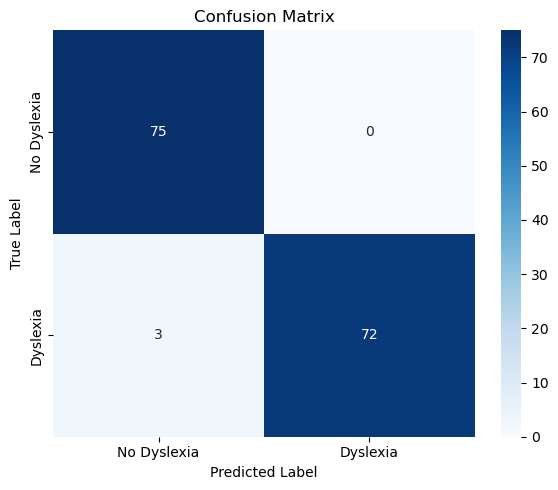


Additional Metrics for Test Results:
Sensitivity (Recall): 0.9600
Specificity: 1.0000
F1 Score: 0.9796

Classification Report:
              precision    recall  f1-score   support

 No Dyslexia       0.96      1.00      0.98        75
    Dyslexia       1.00      0.96      0.98        75

    accuracy                           0.98       150
   macro avg       0.98      0.98      0.98       150
weighted avg       0.98      0.98      0.98       150

ROC AUC Score (Prob-based): 1.0000
PR AUC Score: 1.0000


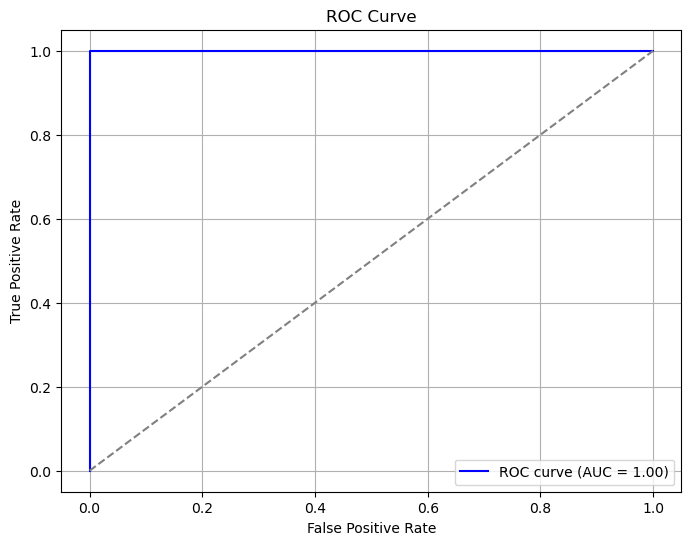

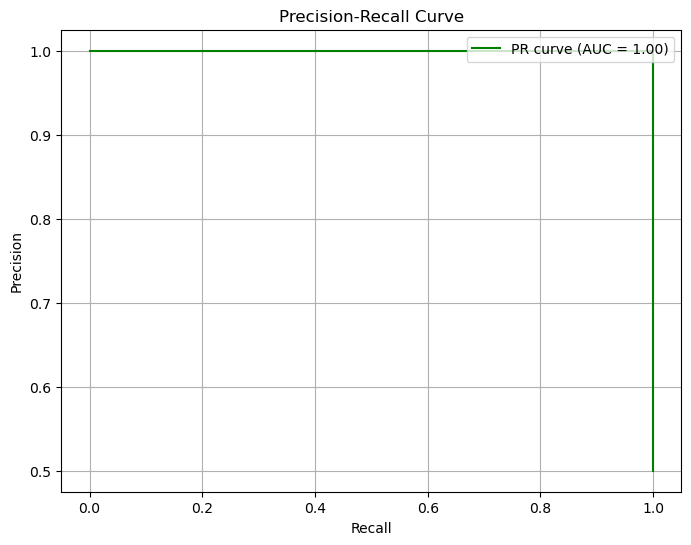

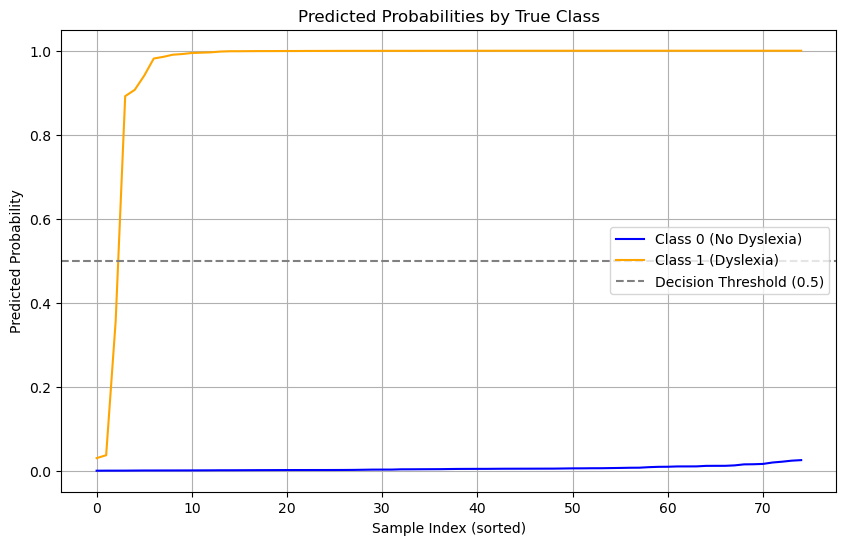


Model training and evaluation complete.


In [18]:
# Noise Image dimensions 
NOISE_IMG_HEIGHT = 224
NOISE_IMG_WIDTH = 224
NOISE_IMG_CHANNELS = 3

# Load MNIST data
(x_train_mnist, y_train_mnist), _ = mnist.load_data()

# Filter for digits 0 and 1 only
digit_images = {
    0: x_train_mnist[y_train_mnist == 0],
    1: x_train_mnist[y_train_mnist == 1]
}

def create_mnist_digit_noise(labels, noise_ratio=0.3):
    """
    For each sample:
      - If label == 0 → correct digit = 0
      - If label == 1 → correct digit = 1
    noise_ratio determines chance to flip the digit.
    """
    structured_noise = []
    for i, label in enumerate(labels):
        correct_digit = label  # 0 or 1
        wrong_digit = 1 - correct_digit

        # With `noise_ratio` chance, change the digit
        use_wrong = np.random.rand() < noise_ratio
        chosen_digit = wrong_digit if use_wrong else correct_digit

        # Randomly pick one digit image
        raw_img = random.choice(digit_images[chosen_digit])

        # Convert 28x28 grayscale to 224x224 RGB
        img_pil = Image.fromarray(raw_img).convert('RGB')
        img_pil = img_pil.resize((NOISE_IMG_WIDTH, NOISE_IMG_HEIGHT))
        img_arr = np.array(img_pil).astype(np.float32)
        img_arr = preprocess_input(img_arr) 
        structured_noise.append(img_arr)

    return np.array(structured_noise)

# Ensure 'text' column is string type and handle potential NaN values
df['text'] = df['text'].fillna('').astype(str) # Fill NaN with empty string, then convert to str
print(f"Total samples: {len(df)}")

# --- Image Preprocessing (Pre-loading all images) ---
print("Loading and preprocessing all images...")
all_images = []
for index, row in df.iterrows():
    image_path = row['file_path']
    full_image_path = image_path
    
    # Check if the image path is valid before trying to open
    if not os.path.exists(full_image_path):
        print(f"Warning: Image file not found at {full_image_path}. Appending black image placeholder.")
        all_images.append(np.zeros((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32))
        continue # Skip

    try:
        img = Image.open(full_image_path)
        
        # Convert to RGB if not already (handles grayscale and RGBA)
        if img.mode != 'RGB':
            img = img.convert('RGB')
            
        # Resize to target dimensions
        img = img.resize((IMG_WIDTH, IMG_HEIGHT))
        
        img_array = np.array(img) / 255.0 # Normalize to [0, 1]
        all_images.append(img_array)
    except Exception as e:
        print(f"Error loading image {full_image_path}: {e}. Appending black image placeholder.")
        all_images.append(np.zeros((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32))

all_images = np.array(all_images)
print(f"All images loaded. Shape: {all_images.shape}")

# --- Text Tokenization (Pre-tokenizing all text) ---
print("Loading BERT tokenizer and tokenizing all text...")
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

all_input_ids = []
all_attention_masks = []

for text_entry in df['text']:
    encoded_input = tokenizer(
        text_entry,
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors='np'
    )
    all_input_ids.append(encoded_input['input_ids'][0])
    all_attention_masks.append(encoded_input['attention_mask'][0])

all_input_ids = np.array(all_input_ids)
all_attention_masks = np.array(all_attention_masks)
print(f"All text tokenized. Input IDs shape: {all_input_ids.shape}, Attention Masks shape: {all_attention_masks.shape}")

# --- Generate Noisy MNIST Data ---
print("Generating MNIST-digit-based structured noise (0 vs 1)...")
all_noise_images = create_mnist_digit_noise(df['presence_of_dyslexia'].values, noise_ratio=0.3)
print(f"Structured noise images created: {all_noise_images.shape}")
print(f"All noise images generated. Shape: {all_noise_images.shape}")


# Step 1: Split into Training (70%) and Temporary (30%)
X_images_train, X_images_temp, \
X_input_ids_train, X_input_ids_temp, \
X_attention_masks_train, X_attention_masks_temp, \
X_noise_train, X_noise_temp, \
y_train, y_temp = train_test_split(
    all_images,
    all_input_ids,
    all_attention_masks,
    all_noise_images, # Add noise images to the split
    df['presence_of_dyslexia'].values,
    test_size=0.3,
    random_state=42,
    stratify=df['presence_of_dyslexia'].values
)

# Step 2: Split the Temporary set (30%) into Validation (15%) and Test (15%)
X_images_val, X_images_test, \
X_input_ids_val, X_input_ids_test, \
X_attention_masks_val, X_attention_masks_test, \
X_noise_val, X_noise_test, \
y_val, y_test = train_test_split(
    X_images_temp,
    X_input_ids_temp,
    X_attention_masks_temp,
    X_noise_temp, # Add noise images to the split
    y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

print(f"Training samples: {len(y_train)}")
print(f"Validation samples: {len(y_val)}")
print(f"Test samples: {len(y_test)}")


# --- Create TensorFlow Datasets from NumPy arrays ---
def create_tf_dataset_from_np(images, input_ids, attention_masks, noise_images, labels, augment=False):
    """
    Creates a TensorFlow Dataset from NumPy arrays.
    Includes an image normalization function for both real and noise images.
    """

    ds = tf.data.Dataset.from_tensor_slices(
        (
            {
                'image_input': images,
                'input_ids': input_ids,
                'attention_mask': attention_masks,
                'noise_input': noise_images # Add noise input here
            },
            labels
        )
    )

    def apply_transformations(inputs, label):
        # Apply normalization to the real image and noise image (using the same normalization as ResNet expects)
        inputs['image_input'] = tf.keras.applications.resnet50.preprocess_input(inputs['image_input'])
        inputs['noise_input'] = tf.keras.applications.resnet50.preprocess_input(inputs['noise_input'])

        if augment:
            img = inputs['image_input']
            img = tf.image.random_flip_left_right(img)
            img = tf.image.random_brightness(img, max_delta=0.2)
            img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
            inputs['image_input'] = img
            
        return inputs, label

    # Map the transformations function over the dataset
    ds = ds.map(apply_transformations, num_parallel_calls=tf.data.AUTOTUNE)

    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_dataset = create_tf_dataset_from_np(X_images_train, X_input_ids_train, X_attention_masks_train, X_noise_train, y_train, augment=False)
val_dataset = create_tf_dataset_from_np(X_images_val, X_input_ids_val, X_attention_masks_val, X_noise_val, y_val, augment=False)
test_dataset = create_tf_dataset_from_np(X_images_test, X_input_ids_test, X_attention_masks_test, X_noise_test, y_test, augment=False)


print("TensorFlow Datasets created from preprocessed NumPy arrays with noise view.")

# --- Custom Keras Layer for BERT Model ---
class BertEmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self, model_name, **kwargs):
        super().__init__(**kwargs)
        self.bert_model = TFAutoModel.from_pretrained(model_name, from_pt=True)
        self.bert_model.trainable = False

    def call(self, inputs):
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        bert_output = self.bert_model(input_ids, attention_mask=attention_mask, training=False)
        return bert_output.last_hidden_state[:, 0, :]

    def get_config(self):
        config = super().get_config()
        config.update({"model_name": "bert-base-cased"}) # Use the actual model name used for loading
        return config

# --- Define the Multi-Modal Model with Noise View ---
print("Building multi-modal model architecture with noise view...")

# Image Branch (ResNet50)
resnet_input = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), name='image_input')
resnet_model = keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=resnet_input
)

# Freeze ResNet50 layers
resnet_model.trainable = False
print("ResNet50 model loaded and layers frozen.")

# Extract features from ResNet50 output
image_features = resnet_model.output
image_features = layers.GlobalAveragePooling2D()(image_features)

# Text Branch (BERT) using the custom layer
bert_input_ids = keras.Input(shape=(128,), dtype=tf.int32, name='input_ids')
bert_attention_mask = keras.Input(shape=(128,), dtype=tf.int32, name='attention_mask')

bert_embedding_extractor = BertEmbeddingLayer("bert-base-cased", name="bert_feature_extractor")
text_features = bert_embedding_extractor({'input_ids': bert_input_ids, 'attention_mask': bert_attention_mask})
print("BERT model wrapped in custom layer and layers frozen.")

# --- Noise Branch (Using ResNet50 with ImageNet weights) ---
noise_input = keras.Input(shape=(NOISE_IMG_HEIGHT, NOISE_IMG_WIDTH, NOISE_IMG_CHANNELS), name='noise_input')

# Create a new ResNet50 instance for the noise branch
# Load ResNet50 base (without including the input_tensor here)
base_noise_resnet = keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(NOISE_IMG_HEIGHT, NOISE_IMG_WIDTH, NOISE_IMG_CHANNELS)
)

# Rename all layers in the noise ResNet to avoid name collisions
for layer in base_noise_resnet.layers:
    layer._name = f"noise_{layer.name}"

# Freeze noise ResNet50 layers
base_noise_resnet.trainable = False

# Apply it to the noise input manually
noise_features = base_noise_resnet(noise_input)
noise_features = layers.GlobalAveragePooling2D()(noise_features)

# Concatenate features from all three modalities
concatenated_features = layers.Concatenate()([image_features, text_features, noise_features])

# Classifier Head (New layers to be trained)
classifier_head = layers.Dense(256, activation='relu')(concatenated_features)
classifier_head = layers.Dropout(0.5)(classifier_head)
#classifier_head = layers.Dense(128, activation='relu')(classifier_head)
#classifier_head = layers.Dropout(0.3)(classifier_head)
output_layer = layers.Dense(1, activation='sigmoid', name='output')(classifier_head)

# Create the final multi-modal model
model = keras.Model(
    inputs={
        'image_input': resnet_input,
        'input_ids': bert_input_ids,
        'attention_mask': bert_attention_mask,
        'noise_input': noise_input # Add noise input to the model inputs
    },
    outputs=output_layer
)

# --- Compile and Train the Model ---
print("Compiling model...")
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

model.summary()

# Define the EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

print("Training model...")
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping_callback]
)

# --- Evaluation ---
print("\nEvaluating model on Test set...")
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

all_preds = []
all_labels = []

for inputs, labels in test_dataset:
    predictions = model.predict(inputs)
    all_preds.extend(predictions.flatten().tolist())
    all_labels.extend(labels.numpy().flatten().tolist())


# Generate predictions and classification report
show_performance_metrics(all_labels, all_preds)

print("\nModel training and evaluation complete.")

# 6 Extend MultiView model with our two original views and a noisy view 
Adding MNIST-style letter images as a structured noise view instead of purely random noise adds a new modality and a controlled noise ratio, which could simulate misleading or adversarial data during multi-view learning.
Test with varying noise levels of 5%, 10%, 15%, 20%


===== Running experiment with noise_ratio = 0.05 =====


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

Done with noise_ratio=0.05: Accuracy=0.9733, F1=0.9726

===== Running experiment with noise_ratio = 0.1 =====


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

Done with noise_ratio=0.1: Accuracy=0.9733, F1=0.9726

===== Running experiment with noise_ratio = 0.15 =====


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

Done with noise_ratio=0.15: Accuracy=0.9733, F1=0.9726

===== Running experiment with noise_ratio = 0.2 =====


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

Done with noise_ratio=0.2: Accuracy=0.9733, F1=0.9726

===== Running experiment with noise_ratio = 0.25 =====


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

Done with noise_ratio=0.25: Accuracy=0.9733, F1=0.9726

=== Summary of Results ===
   noise_ratio  test_accuracy  test_loss  precision    recall        f1
0         0.05       0.973333   0.042395        1.0  0.946667  0.972603
1         0.10       0.973333   0.078836        1.0  0.946667  0.972603
2         0.15       0.973333   0.067393        1.0  0.946667  0.972603
3         0.20       0.973333   0.112862        1.0  0.946667  0.972603
4         0.25       0.973333   0.059432        1.0  0.946667  0.972603


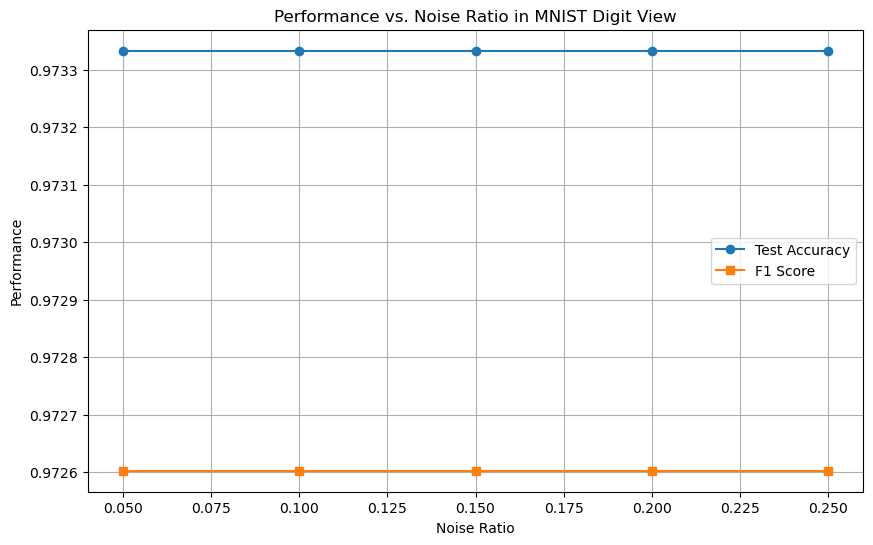

In [19]:
digit_images = {
    0: x_train_mnist[y_train_mnist == 0],
    1: x_train_mnist[y_train_mnist == 1]
}

def build_multimodal_model(img_height, img_width, img_channels, noise_height, noise_width, noise_channels, image_input, image_features, input_ids,attention_mask, text_features):

    # --- Noise Branch (Using ResNet50 with ImageNet weights) ---
    noise_input = keras.Input(shape=(NOISE_IMG_HEIGHT, NOISE_IMG_WIDTH, NOISE_IMG_CHANNELS), name='noise_input')

    # Create a new ResNet50 instance for the noise branch
    # Load ResNet50 base (without including the input_tensor here)
    base_noise_resnet = keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(NOISE_IMG_HEIGHT, NOISE_IMG_WIDTH, NOISE_IMG_CHANNELS)
    )

    # Rename all layers in the noise ResNet to avoid name collisions
    for layer in base_noise_resnet.layers:
        layer._name = f"noise_{layer.name}"

    # Freeze noise ResNet50 layers
    base_noise_resnet.trainable = False

    # Apply it to the noise input manually
    noise_features = base_noise_resnet(noise_input)
    noise_features = layers.GlobalAveragePooling2D()(noise_features)

    # --- Concatenate Modalities ---
    concatenated = layers.Concatenate()([image_features, text_features, noise_features])

    # --- Classifier Head ---
    x = layers.Dense(256, activation='relu')(concatenated)
    x = layers.Dropout(0.5)(x)
    #x = layers.Dense(128, activation='relu')(x)
    #x = layers.Dropout(0.3)(x)
    output = layers.Dense(1, activation='sigmoid', name='output')(x)

    # --- Full Model ---
    model = Model(
        inputs={
            'image_input': image_input,
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'noise_input': noise_input
        },
        outputs=output
    )

    return model
    
def run_experiment_with_noise_ratio(noise_ratio, df, 
                                     IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS,
                                     tokenizer, BATCH_SIZE=16, EPOCHS=30):
    print(f"\n===== Running experiment with noise_ratio = {noise_ratio} =====")

    # Generate structured noise using MNIST digits
    all_noise_images = create_mnist_digit_noise(df['presence_of_dyslexia'].values, noise_ratio=noise_ratio)

    # Prepare images
    # Prepare tokenized text (already done earlier)
    # Use: all_images, all_input_ids, all_attention_masks

    # Split data
    X_images_train, X_images_temp, \
    X_input_ids_train, X_input_ids_temp, \
    X_attention_masks_train, X_attention_masks_temp, \
    X_noise_train, X_noise_temp, \
    y_train, y_temp = train_test_split(
        all_images,
        all_input_ids,
        all_attention_masks,
        all_noise_images,
        df['presence_of_dyslexia'].values,
        test_size=0.3,
        random_state=seed,
        stratify=df['presence_of_dyslexia'].values
    )

    X_images_val, X_images_test, \
    X_input_ids_val, X_input_ids_test, \
    X_attention_masks_val, X_attention_masks_test, \
    X_noise_val, X_noise_test, \
    y_val, y_test = train_test_split(
        X_images_temp,
        X_input_ids_temp,
        X_attention_masks_temp,
        X_noise_temp,
        y_temp,
        test_size=0.5,
        random_state=seed,
        stratify=y_temp
    )

    # Create TF Datasets
    train_dataset = create_tf_dataset_from_np(X_images_train, X_input_ids_train, X_attention_masks_train, X_noise_train, y_train, augment=False)
    val_dataset = create_tf_dataset_from_np(X_images_val, X_input_ids_val, X_attention_masks_val, X_noise_val, y_val, augment=False)
    test_dataset = create_tf_dataset_from_np(X_images_test, X_input_ids_test, X_attention_masks_test, X_noise_test, y_test, augment=False)

    # --- Image Branch (ResNet50) ---
    image_input = Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), name='image_input')
    resnet_base = keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_tensor=image_input
    )
    resnet_base.trainable = False  # freeze ResNet
    image_features = layers.GlobalAveragePooling2D()(resnet_base.output)

    # --- Text Branch (BERT) ---
    bert_input_ids = keras.Input(shape=(128,), dtype=tf.int32, name='input_ids')
    bert_attention_mask = keras.Input(shape=(128,), dtype=tf.int32, name='attention_mask')

    # BERT embedding extraction
    bert_embedding_extractor = BertEmbeddingLayer("bert-base-cased", name="bert_feature_extractor")
    text_features = bert_embedding_extractor({
    'input_ids': bert_input_ids,
    'attention_mask': bert_attention_mask
    })

    # Rebuild and compile model
    model = build_multimodal_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, NOISE_IMG_HEIGHT, NOISE_IMG_WIDTH, NOISE_IMG_CHANNELS, image_input=image_input, 
    image_features=image_features, input_ids=bert_input_ids,attention_mask=bert_attention_mask, text_features=text_features)  # Wrap  model construction into a function
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)

    # Train
    history = model.fit(train_dataset,
                        epochs=EPOCHS,
                        validation_data=val_dataset,
                        callbacks=[early_stopping],
                        verbose=0)  # silent training for batch runs

    # Evaluate
    test_loss, test_acc = model.evaluate(test_dataset, verbose=0)

    # Predictions for classification report
    preds, true_labels = [], []
    for batch_inputs, batch_labels in test_dataset:
        batch_preds = model.predict(batch_inputs, verbose=0).flatten()
        preds.extend(batch_preds)
        true_labels.extend(batch_labels.numpy())

    binary_preds = np.array(preds) > 0.5
    report = classification_report(true_labels, binary_preds, output_dict=True)

    return {
        'noise_ratio': noise_ratio,
        'test_accuracy': test_acc,
        'test_loss': test_loss,
        'precision': report['1']['precision'],
        'recall': report['1']['recall'],
        'f1': report['1']['f1-score']
    }

results = []
noise_ratios = [0.05, 0.1, 0.15, 0.2, 0.25]

for ratio in noise_ratios:
    result = run_experiment_with_noise_ratio(
        noise_ratio=ratio,
        df=df,
        IMG_HEIGHT=IMG_HEIGHT,
        IMG_WIDTH=IMG_WIDTH,
        IMG_CHANNELS=IMG_CHANNELS,
        tokenizer=tokenizer,
        BATCH_SIZE=16,
        EPOCHS=30
    )
    results.append(result)
    print(f"Done with noise_ratio={ratio}: Accuracy={result['test_accuracy']:.4f}, F1={result['f1']:.4f}")

results_df = pd.DataFrame(results)
print("\n=== Summary of Results ===")
print(results_df)

plt.figure(figsize=(10, 6))
plt.plot(results_df['noise_ratio'], results_df['test_accuracy'], marker='o', label='Test Accuracy')
plt.plot(results_df['noise_ratio'], results_df['f1'], marker='s', label='F1 Score')
plt.xlabel("Noise Ratio")
plt.ylabel("Performance")
plt.title("Performance vs. Noise Ratio in MNIST Digit View")
plt.legend()
plt.grid(True)
plt.show()